### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 2

**Student Name:**    `TANZID SULTAN`

**Student ID:**     `1430660`

## This iPython notebook is a template which you should use for your Assignment 2 submission. This file should be submitted at the **Assignment 2: Code** link on the LMS.

In addition to this file, you should submit a written report explaining your results at the **Assignment 2: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. CNN training

The following code section will load the dataset from a folder that you specify. You may change the batch sizes and add additional data augmentation steps here if you wish.

In [2]:
# library imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model

# make sure GPU is available
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-06 21:27:34.780641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-06 21:27:34.973598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-06 21:27:34.974872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


#### ImageDataGenerators with image augmentation for training data set only

In [137]:

data_dir = 'scene32' # SPECIFY YOUR PATH TO THE DATASET
batch_size = 80

# Data generator for training
# Additional data augmentation may be added here if desired
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,                    # flip horizontally (*)
    rotation_range=10,                       # random rotations (*)
    width_shift_range=0.3,                   # random horizontal translations (***)
    height_shift_range=0.3,                  # random vertical translations (***)
    zoom_range=0.1,                          # random zooming (**)
    fill_mode= 'nearest' 
    )

# Data generator for test
# DO NOT USE DATA AUGMENTATION WITH TEST SET
test_datagen = ImageDataGenerator(
    rescale=1./255)

# Generate training data from 'train' directory
train_data = train_datagen.flow_from_directory(
        data_dir+'/train',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=1)

# Generate vaildation data from 'valid' directory
val_data = test_datagen.flow_from_directory(
        data_dir+'/valid',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=1)

# Generate test data from 'test' directory
test_data = test_datagen.flow_from_directory(
        data_dir+'/test',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# Output list of class names
class_names_and_indices = train_data.class_indices
print(class_names_and_indices)

# Note: To train a model with the dataset loaded above, pass the train and val
# datasets to the fit() function, like so:
# myModel.fit(train_data, validation_data=val_data, ...)

Found 1440 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}


#### Build a CNN model according to specs

In [346]:
# initial learning rate
lr = 0.001 
# scehduler for exponentially decaying learning rate
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=300, decay_rate=0.8)
# weight initializers
initializer1 = tf.keras.initializers.GlorotNormal(seed=1)
initializer2 = tf.keras.initializers.GlorotNormal(seed=2)
initializer3 = tf.keras.initializers.GlorotNormal(seed=3)
initializer4 = tf.keras.initializers.GlorotNormal(seed=4)

# build the model
cnn1 = keras.Sequential(
    [
        layers.Input((32,32,3)),                                                                         # input image shape is 32x32x3  
        layers.Conv2D(16, (3,3), padding='valid', activation='relu', kernel_initializer=initializer1),
        layers.BatchNormalization(),                                                                     # batch normalization to speed up training
        layers.Conv2D(16, (3,3), padding='valid', activation='relu', kernel_initializer=initializer2),
        layers.BatchNormalization(),                                                                     # batch normalization to speed up training
        layers.MaxPooling2D((2,2), strides=(2,2), padding='valid'),
        layers.Flatten(), 
        layers.Dropout(0.2),                                                                               # unravel the 3d tensor from the previous layer output
        layers.Dense(64, activation='relu', kernel_initializer=initializer3),  
        layers.Dense(8, activation='softmax', kernel_initializer=initializer4)                           # output layer with 8 neurons, corresponding to the 8 categories
    ]
)


# configure the model
cnn1.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# display model summary
#cnn1.summary()

#### Train the model for 150 epochs

In [347]:
# train the model 
history_cnn1_aug = cnn1.fit(train_data, validation_data=val_data, epochs=150, verbose=1) 

Epoch 1/150


2023-09-07 02:38:16.455097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


18/18 [==============================] - 2s 36ms/step - loss: 2.1278 - accuracy: 0.3306 - val_loss: 2.0547 - val_accuracy: 0.1406
Epoch 2/150
 1/18 [>.............................] - ETA: 0s - loss: 1.5985 - accuracy: 0.3875

2023-09-07 02:38:18.065505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


18/18 [==============================] - 1s 31ms/step - loss: 1.5768 - accuracy: 0.4694 - val_loss: 2.0515 - val_accuracy: 0.1312
Epoch 3/150
18/18 [==============================] - 1s 30ms/step - loss: 1.3797 - accuracy: 0.5243 - val_loss: 2.0242 - val_accuracy: 0.1250
Epoch 4/150
18/18 [==============================] - 1s 29ms/step - loss: 1.2577 - accuracy: 0.5583 - val_loss: 2.2288 - val_accuracy: 0.1281
Epoch 5/150
18/18 [==============================] - 1s 27ms/step - loss: 1.2437 - accuracy: 0.5549 - val_loss: 2.3310 - val_accuracy: 0.1406
Epoch 6/150
18/18 [==============================] - 1s 30ms/step - loss: 1.0685 - accuracy: 0.6271 - val_loss: 2.5685 - val_accuracy: 0.1250
Epoch 7/150
18/18 [==============================] - 1s 30ms/step - loss: 1.0732 - accuracy: 0.6250 - val_loss: 3.1073 - val_accuracy: 0.1219
Epoch 8/150
18/18 [==============================] - 1s 30ms/step - loss: 1.0864 - accuracy: 0.6132 - val_loss: 3.3117 - val_accuracy: 0.1281
Epoch 9/150
18/18 

#### Plot learning curves

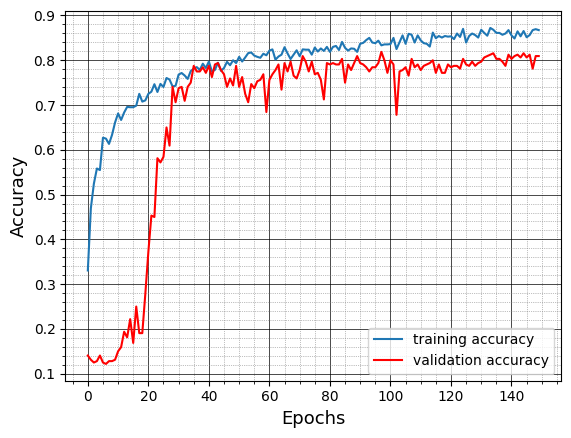

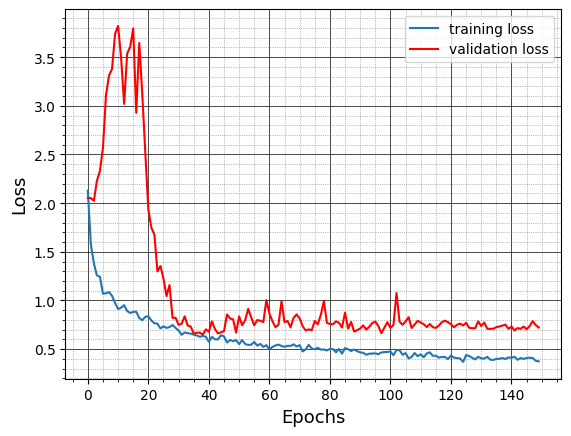

In [354]:
# plot some learning curves
def plot_graphs(training_history, metric):
    #fig = plt.figure(figsize=(5, 5))
    plt.plot(training_history.history[metric])
    plt.plot(training_history.history["val_"+metric], 'r')
    plt.xlabel("Epochs", fontsize=13)
    plt.ylabel(metric.capitalize(), fontsize=13)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

    plt.legend(["training "+metric, "validation "+metric])
    plt.show()

plot_graphs(history_cnn1_aug, "accuracy")
plot_graphs(history_cnn1_aug, "loss")


#### Evaluate model accuracy on test data

In [355]:
test_results = cnn1.evaluate(test_data)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

4/4 [==============================] - 0s 10ms/step - loss: 0.6916 - accuracy: 0.7844
Test results - Loss: 0.6916369795799255 - Accuracy: 78.4375011920929%


2023-09-07 03:02:16.635183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


### 2. Error anaylsis

#### For this section, we evaluate the model's prediction accuracy for each class

In [570]:
def class_average(model):
    # get the test images and class probabilities
    xs, ys = [], []
    n_batches = int(np.ceil(test_data.n/test_data.batch_size))
    for i in range(n_batches):
        x_batch, y_batch = next(test_data)
        xs.append(x_batch)
        ys.append(y_batch)
    x_test = np.concatenate(xs, axis=0)    
    y_test = np.concatenate(ys, axis=0)

    # convert class probabilities to class label
    labels = np.argmax(test_labels, axis=1) 

    # compute predicted class probabilities and labels for test data
    y_preds = model.predict(x_test) 
    labels_preds = np.argmax(y_preds, axis=1) 

    # compute accuracy per class
    n_class = 8
    n_img_per_class = 40 
    class_names = {c_index : c_name for (c_name, c_index) in class_names_and_indices.items()}
    n_correct_tot = 0
    for i in range(n_class):
        n_correct = np.sum(np.equal(labels_preds[i*n_img_per_class : (i+1)*n_img_per_class], labels[i*n_img_per_class : (i+1)*n_img_per_class]))
        n_correct_tot += n_correct
        print(f"Class: {class_names[i]}, Number of correct predictions: {n_correct}/{n_img_per_class}, Average Accuracy: {n_correct/n_img_per_class}")
        
    print(f"\nOverall classification accuracy for test data: {n_correct_tot/(n_class * n_img_per_class)}")


    # plot confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(labels, labels_preds, display_labels= class_names_and_indices.keys(), colorbar=False)
    fig = disp.figure_
    fig.set_figwidth(9)
    fig.set_figheight(9) 

In [358]:
class_average(cnn1)

10/10 [==============================] - 0s 4ms/step
Class: coast, Number of correct predictions: 29/40, Average Accuracy: 0.725
Class: forest, Number of correct predictions: 33/40, Average Accuracy: 0.825
Class: highway, Number of correct predictions: 33/40, Average Accuracy: 0.825
Class: insidecity, Number of correct predictions: 38/40, Average Accuracy: 0.95
Class: mountain, Number of correct predictions: 33/40, Average Accuracy: 0.825
Class: opencountry, Number of correct predictions: 20/40, Average Accuracy: 0.5
Class: street, Number of correct predictions: 31/40, Average Accuracy: 0.775
Class: tallbuilding, Number of correct predictions: 34/40, Average Accuracy: 0.85

Overall classification accuracy for test data: 0.784375


#### It is also useful to plot a confusion matrix so that we can see if there are any obvious patterns in how the model misclassifies images from certain classes and identify if there are certain classes which are more difficult for the model to classify.

#### It looks like 'street', 'tallbuilding' and 'highway' images are frequently miscalssified as being 'insidecity', not too surprising as these classes share lots of similar features, e.g. asphalt/roads are present across all of these classes. 'Mountain' is mostly misclassified as either 'forest', 'insidecity' or 'tallbuilding'. 'opencountry' is the hardest to classify followed by 'coast'. Both of these classes share significantly similar features with many of the other classes, such as open skies and large expanses of land. 

#### Now lets look at some of the mis-calssified images

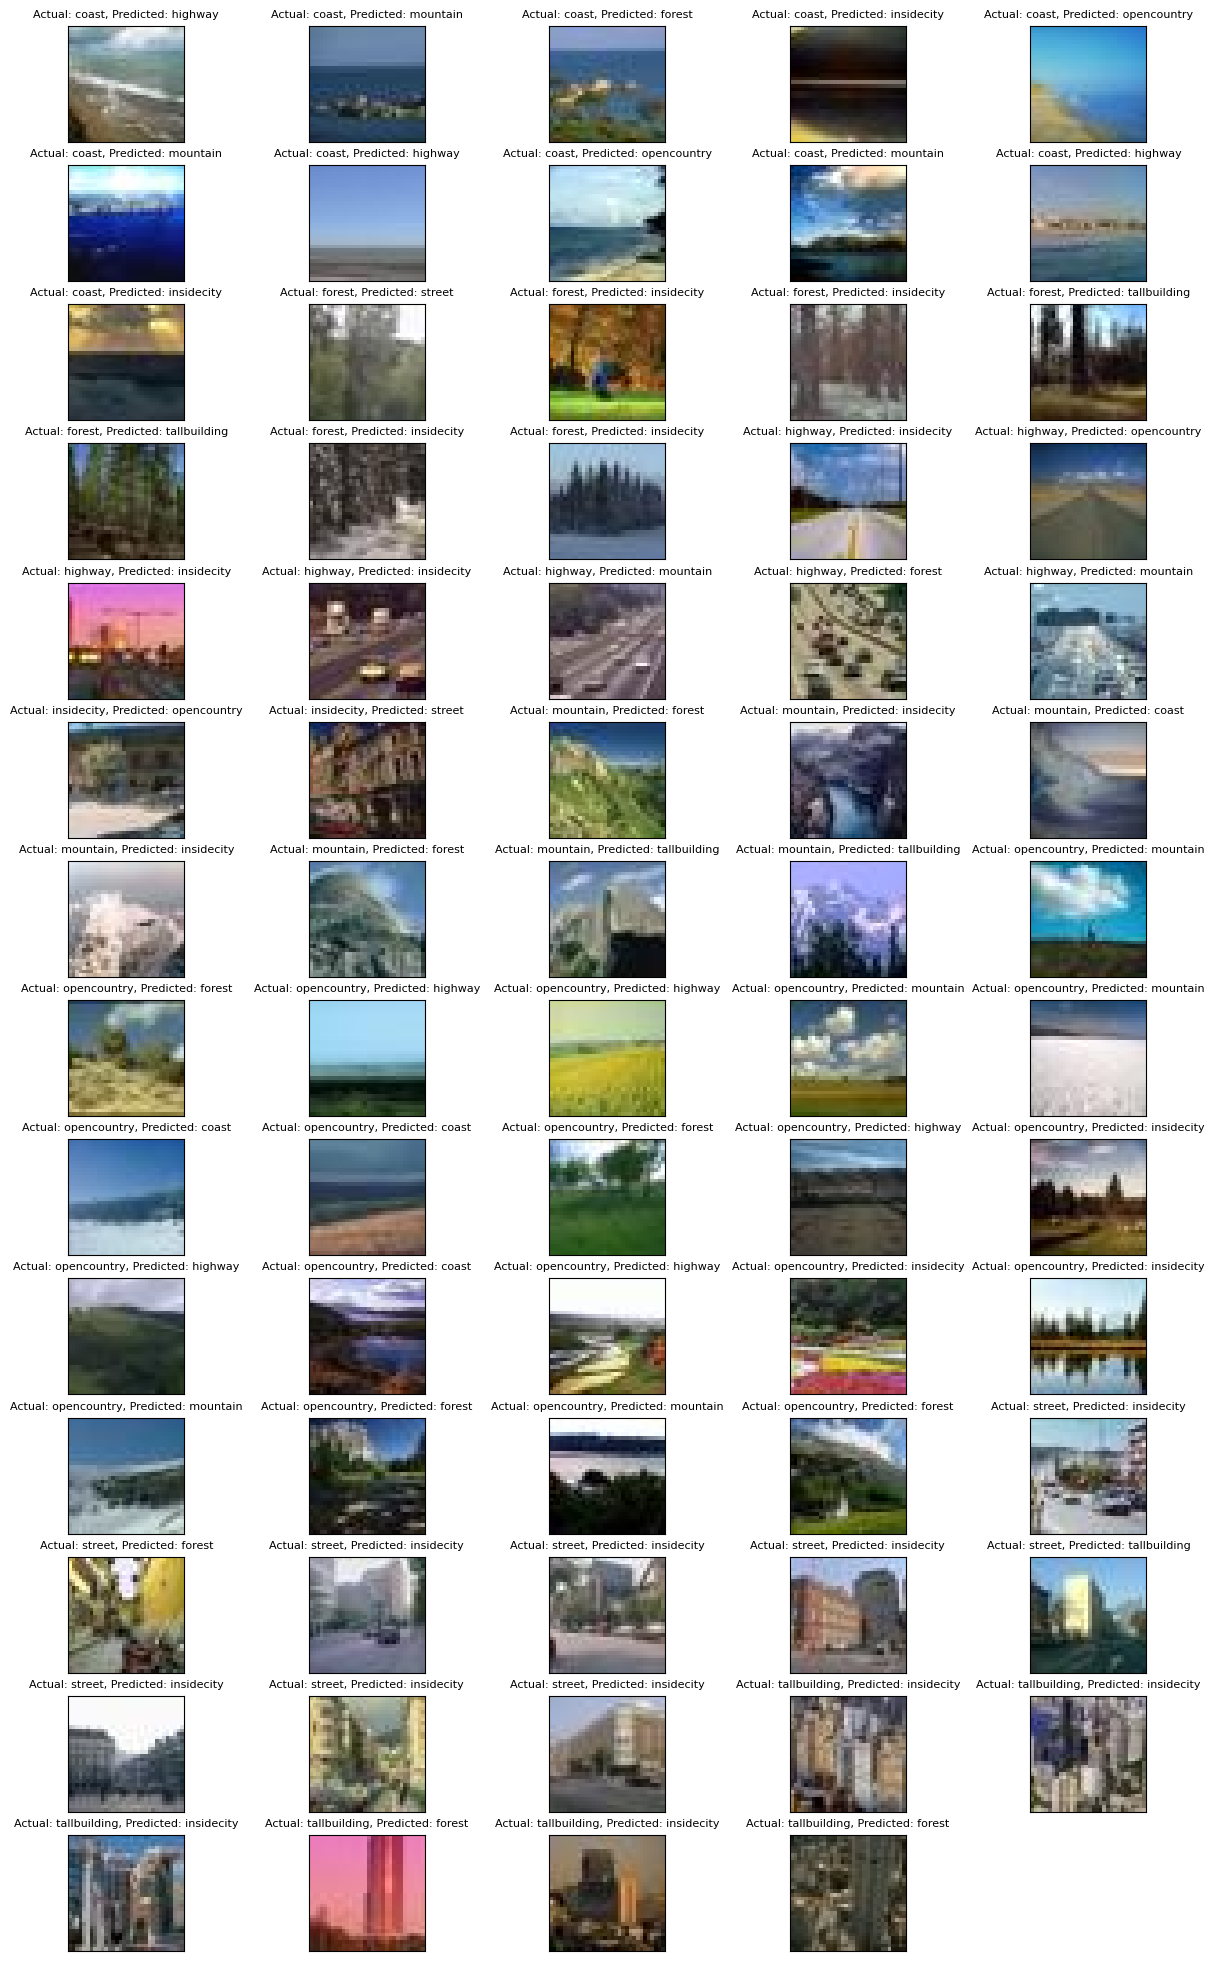

In [384]:
# plot misclassified images from each class

fig = plt.figure(figsize=(15, 25))

n_images = x_test.shape[0]
n_incorrect = n_images - np.sum(np.equal(labels_preds, labels))
ix = 1
for i in range(n_images):
    if(labels[i] != labels_preds[i]):
        ax = plt.subplot(int(np.ceil(n_incorrect/5)), 5, ix)
        plt.imshow(x_test[i])
        plt.title(f"Actual: {class_names[labels[i]]}, Predicted: {class_names[labels_preds[i]]}", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ix += 1

plt.show()        

### 3. Kernel engineering

#### For this section, we train a CNN Model with only one Conv layer with K x K filters for varying K. For each K, we repeat the training 3 times and keep the average test set accuracy for a smoother estimate.

In [585]:
# filter sizes
kernel_sizes = [2,3,4,5,7,9,12,16,20,25,30]

In [610]:
accuracies_k = []
conv_layer_k = []
filters_k = []

# train model for each different filter size
for k in kernel_sizes:

    print(f"k = {k}")

    test_acc = []
    
    # repeat training for each k three times to get smoother estimate of test accuracy 
    for j in range()
        
        # initial learning rate
        lr = 0.001 
        # scehduler for exponentially decaying learning rate
        lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100, decay_rate=0.8)
        # weight initializers
        initializer1 = tf.keras.initializers.GlorotNormal(seed=1)
        initializer2 = tf.keras.initializers.GlorotNormal(seed=2)
        initializer3 = tf.keras.initializers.GlorotNormal(seed=3)

        # build the model
        cnn2 = keras.Sequential(
            [
                layers.Input((32,32,3)),                                                                         # input image shape is 32x32x3  
                layers.Conv2D(16, (k,k), padding='valid', activation='relu', kernel_initializer=initializer1),
                layers.BatchNormalization(),                                                                     # batch normalization to speed up training
                layers.MaxPooling2D((2,2), strides=(2,2), padding='valid'),
                layers.Flatten(), 
                #layers.Dropout(0.2),                                                                            # unravel the 3d tensor from the previous layer output
                layers.Dense(64, activation='relu', kernel_initializer=initializer2),  
                layers.Dense(8, activation='softmax', kernel_initializer=initializer3)                           # output layer with 8 neurons, corresponding to the 8 categories
            ]
        )


        # configure the model
        cnn2.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

        # display model summary
        #cnn2.summary()

        # train the model again, this time with augmented images
        history_cnn2 = cnn2.fit(train_data, validation_data=val_data, epochs=300, verbose=0) 

        # Evaluate model performance on the test data
        test_results = cnn2.evaluate(test_data)
        print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

        test_acc.append(test_results[1])
        
        # plot learning curve
        # plot_graphs(history_cnn2, "accuracy")
        # plot_graphs(history_cnn2, "loss")
   
    # get filter weights
    f, _ = cnn2.layers[0].get_weights()
    # normalize the values to be in [0,1] for visualization purposes
    f_min , f_max = f.min(), f.max()
    f = (f-f_min) / (f_max- f_min)
    
    # get a copy of the conv layer
    conv_layer_k.append(cnn2.layers[0])
    filters_k.append(f)
    # keep average test accuracy 
    accuracies_k.append(sum(test_acc)/len(test_acc))


k = 5


2023-09-08 14:32:35.564251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-08 14:32:36.842410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 0s 8ms/step - loss: 0.7440 - accuracy: 0.7500
Test results - Loss: 0.7440334558486938 - Accuracy: 75.0%


2023-09-08 14:35:13.496352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


#### Plot the test accuracy vs kernel size. Note that test accuracy decreases as filter size increases

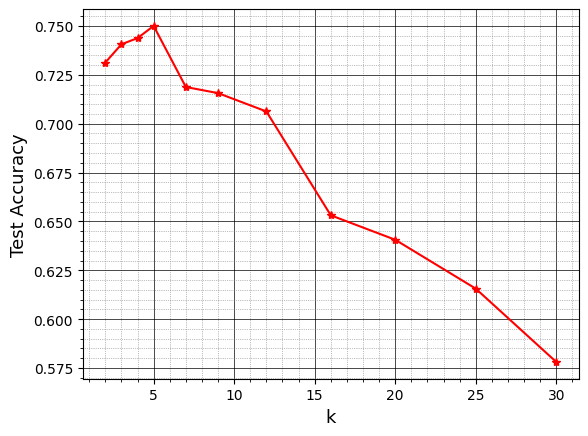

In [614]:
# plot the test acuuracy vs k
plt.plot(kernel_sizes, accuracies_k, 'r*-')
plt.xlabel("k", fontsize=13)
plt.ylabel("Test Accuracy", fontsize=13)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

#### We now visualize the filters learned by our model at a few different K

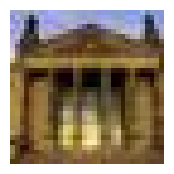

In [642]:
# load an image from the training set
img = load_img(data_dir+'/train/insidecity/insidecity_a129035.jpg', target_size=(32, 32))

fig = plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.axis('off')
plt.show()

# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

#### k = 2

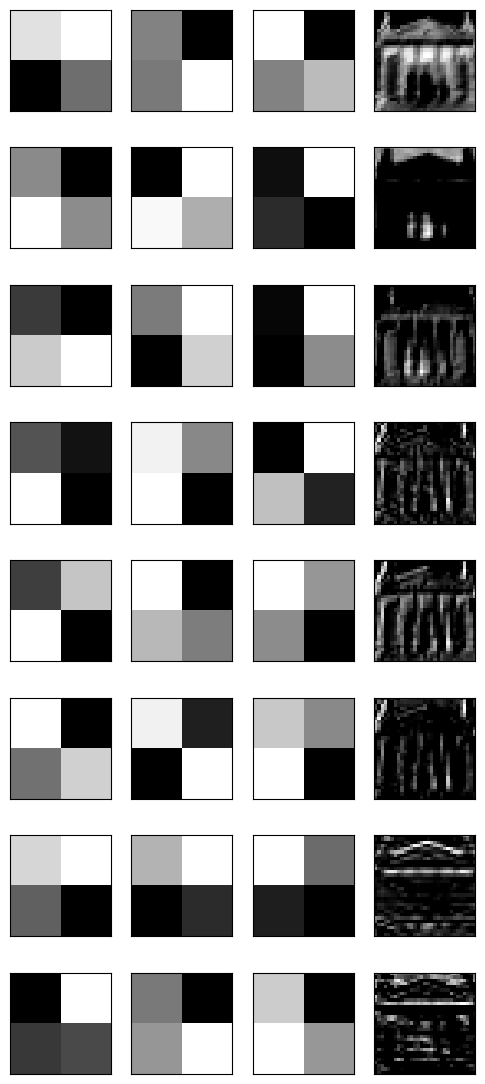

In [665]:
# get filters
filters = filters_k[0]

# get feature map for conv layer
feature_maps = conv_layer_k[0](img)

fig = plt.figure(figsize=(6, 14))
ix =  1

# display every other filter
for i in range(0,16,2):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(4):
        # subplot for 6 filters and 3 channels and activation map in grayscale
        # specify subplot and turn of axis
        ax = plt.subplot(8, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if j < 3:    
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
        else:
            # plot feature map in grayscale
            plt.imshow(feature_maps[0,:,:,i] , cmap='gray')

        ix += 1
# plot the filters
plt.show()

#### k = 5

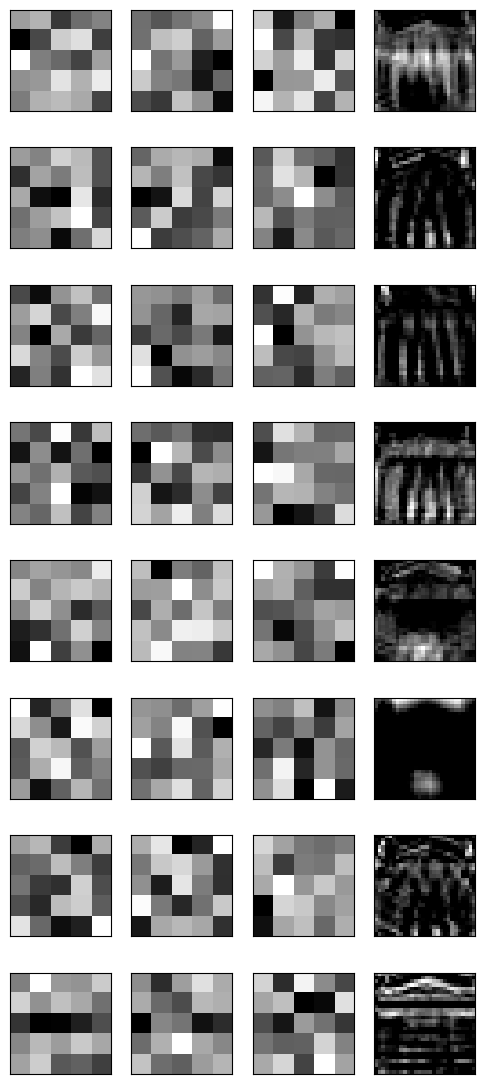

In [664]:
# get filters
filters = filters_k[3]

# get feature map for conv layer
feature_maps = conv_layer_k[3](img)

fig = plt.figure(figsize=(6, 14))
ix =  1

# display every other filter
for i in range(0,16,2):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(4):
        # subplot for 6 filters and 3 channels and activation map in grayscale
        # specify subplot and turn of axis
        ax = plt.subplot(8, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if j < 3:    
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
        else:
            # plot feature map in grayscale
            plt.imshow(feature_maps[0,:,:,i] , cmap='gray')

        ix += 1
# plot the filters
plt.show()

#### k = 12

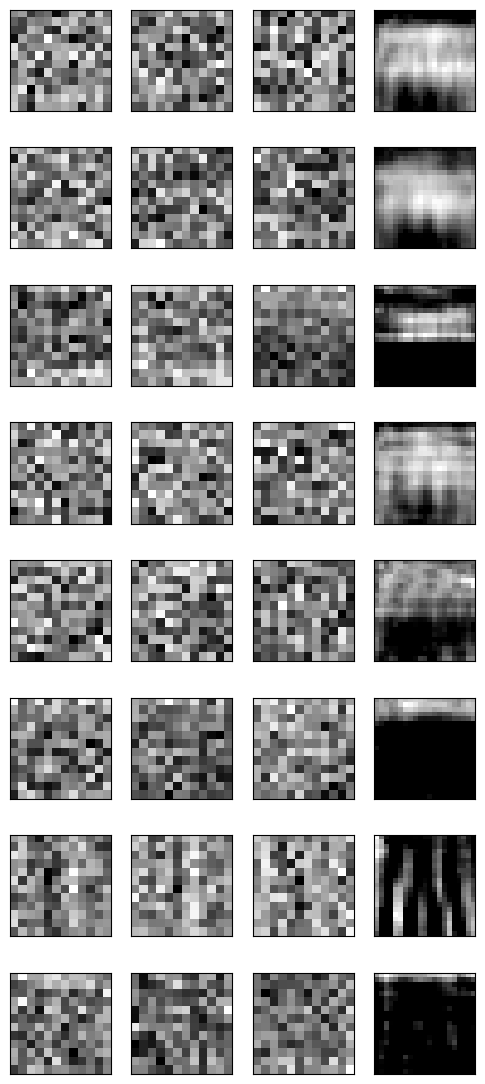

In [661]:
# get filters
filters = filters_k[6]

# get feature map for conv layer
feature_maps = conv_layer_k[6](img)

fig = plt.figure(figsize=(6, 14))
ix =  1

# display every other filter
for i in range(0,16,2):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(4):
        # subplot for 6 filters and 3 channels and activation map in grayscale
        # specify subplot and turn of axis
        ax = plt.subplot(8, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if j < 3:    
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
        else:
            # plot feature map in grayscale
            plt.imshow(feature_maps[0,:,:,i] , cmap='gray')

        ix += 1
# plot the filters
plt.show()

#### k = 25

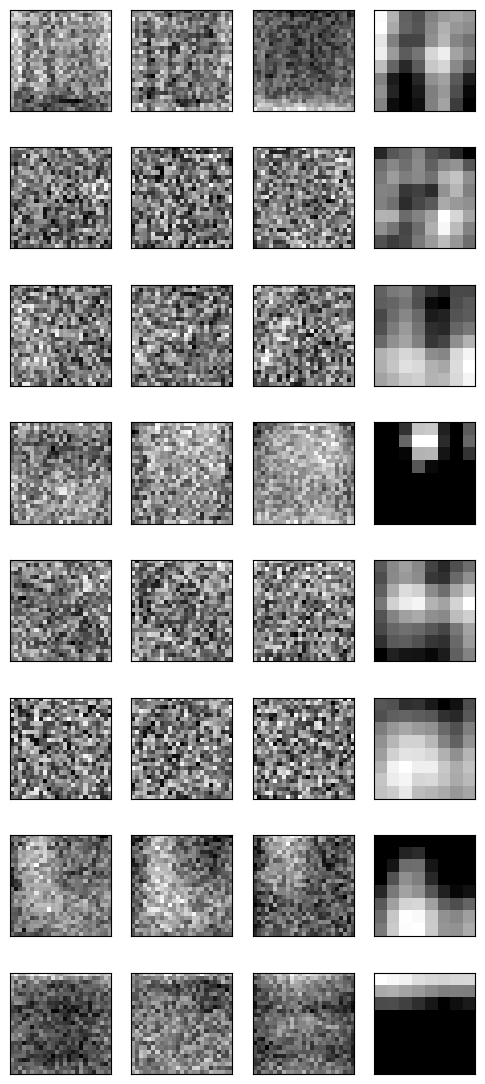

In [662]:
# get filters
filters = filters_k[9]

# get feature map for conv layer
feature_maps = conv_layer_k[9](img)

fig = plt.figure(figsize=(6, 14))
ix =  1

# display every other filter
for i in range(0,16,2):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(4):
        # subplot for 6 filters and 3 channels and activation map in grayscale
        # specify subplot and turn of axis
        ax = plt.subplot(8, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if j < 3:    
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
        else:
            # plot feature map in grayscale
            plt.imshow(feature_maps[0,:,:,i] , cmap='gray')

        ix += 1
# plot the filters
plt.show()

#### k = 30

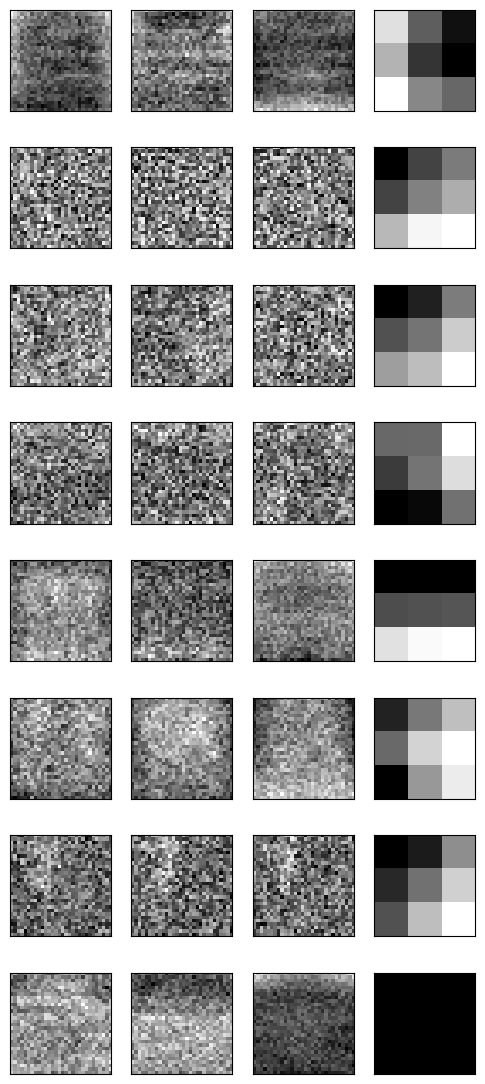

In [663]:
# get filters
filters = filters_k[-1]

# get feature map for conv layer
feature_maps = conv_layer_k[-1](img)

fig = plt.figure(figsize=(6, 14))
ix =  1

# display every other filter
for i in range(0,16,2):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(4):
        # subplot for 6 filters and 3 channels and activation map in grayscale
        # specify subplot and turn of axis
        ax = plt.subplot(8, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if j < 3:    
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
        else:
            # plot feature map in grayscale
            plt.imshow(feature_maps[0,:,:,i] , cmap='gray')

        ix += 1
# plot the filters
plt.show()